In [1]:
!pip install napari

  Using cached napari-0.5.4-py3-none-any.whl (3.1 MB)
  Using cached app_model-0.3.0-py3-none-any.whl (64 kB)
  Using cached cachey-0.2.1-py3-none-any.whl (6.4 kB)
  Using cached dask-2024.11.2-py3-none-any.whl (1.3 MB)
  Using cached magicgui-0.9.1-py3-none-any.whl (124 kB)
  Using cached napari_console-0.1.1-py3-none-any.whl (10.0 kB)
  Using cached napari_plugin_engine-0.2.0-py3-none-any.whl (33 kB)
  Using cached napari_svg-0.2.0-py3-none-any.whl (15 kB)
  Using cached npe2-0.7.7-py3-none-any.whl (92 kB)
  Using cached numpydoc-1.8.0-py3-none-any.whl (64 kB)
  Using cached Pint-0.24.4-py3-none-any.whl (302 kB)
  Using cached psygnal-0.11.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (717 kB)
  Using cached PyOpenGL-3.1.7-py3-none-any.whl (2.4 MB)
  Using cached QtPy-2.4.2-py3-none-any.whl (95 kB)
  Using cached superqt-0.6.7-py3-none-any.whl (90 kB)
  Using cached vispy-0.14.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.9 MB)
  Using cached wrapt-1.

In [2]:
!pip install imagecodecs

  Using cached imagecodecs-2024.9.22-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (45.5 MB)


In [ ]:
my directory looks like
least squares
|
-----test_deconv
|----matlab_decon_omw_wienerAlpha0.002
|----matlab_decon_omw_wienerAlpha0....
-----ground truth stuff

Initialization:

Ground Truth Files:
- er: True (/home/jovyan/least squares/er_gt_px_108nm.tif)
- mito: True (/home/jovyan/least squares/mito_gt_px_108nm.tif)

Wiener Alpha Folders Found: 6
- matlab_decon_omw_wienerAlpha0.002
- matlab_decon_omw_wienerAlpha0.043684
- matlab_decon_omw_wienerAlpha0.054105
- matlab_decon_omw_wienerAlpha0.14789
- matlab_decon_omw_wienerAlpha0.2
- matlab_decon_omw_wienerAlpha0.095789

Starting analysis...
Memory usage: 662.17 MB

Processing folder: matlab_decon_omw_wienerAlpha0.002
Memory usage: 662.17 MB

Analyzing: CamB_ch0_er_simulated_raw_Confocal_1AU_px_108nm_0lambda_snr_16.tif
Parameters: {'channel': 'er', 'snr': 16, 'wiener': 0.002}
Memory usage: 681.90 MB

Analyzing: CamB_ch0_mito_simulated_raw_Confocal_1AU_px_108nm_0lambda_snr_16.tif
Parameters: {'channel': 'mito', 'snr': 16, 'wiener': 0.002}
Memory usage: 701.52 MB

Processing folder: matlab_decon_omw_wienerAlpha0.043684
Memory usage: 701.52 MB

Analyzing: CamB_ch0_er_simulated_raw_Confocal_1AU_px_

<tifffile.TiffPages @103008> invalid page offset 7383638


Memory usage: 740.74 MB

Processing folder: matlab_decon_omw_wienerAlpha0.054105
Memory usage: 740.74 MB

Analyzing: CamB_ch0_er_simulated_raw_Confocal_1AU_px_108nm_0lambda_snr_16.tif
Parameters: {'channel': 'er', 'snr': 16, 'wiener': 0.054105}
Memory usage: 742.95 MB

Analyzing: CamB_ch0_mito_simulated_raw_Confocal_1AU_px_108nm_0lambda_snr_16.tif
Parameters: {'channel': 'mito', 'snr': 16, 'wiener': 0.054105}
Memory usage: 771.26 MB

Processing folder: matlab_decon_omw_wienerAlpha0.14789
Memory usage: 771.26 MB

Analyzing: CamB_ch0_er_simulated_raw_Confocal_1AU_px_108nm_0lambda_snr_16.tif
Parameters: {'channel': 'er', 'snr': 16, 'wiener': 0.14789}
Memory usage: 790.86 MB

Analyzing: CamB_ch0_mito_simulated_raw_Confocal_1AU_px_108nm_0lambda_snr_16.tif
Parameters: {'channel': 'mito', 'snr': 16, 'wiener': 0.14789}
Memory usage: 810.46 MB

Processing folder: matlab_decon_omw_wienerAlpha0.2
Memory usage: 810.46 MB

Analyzing: CamB_ch0_er_simulated_raw_Confocal_1AU_px_108nm_0lambda_snr_16.ti

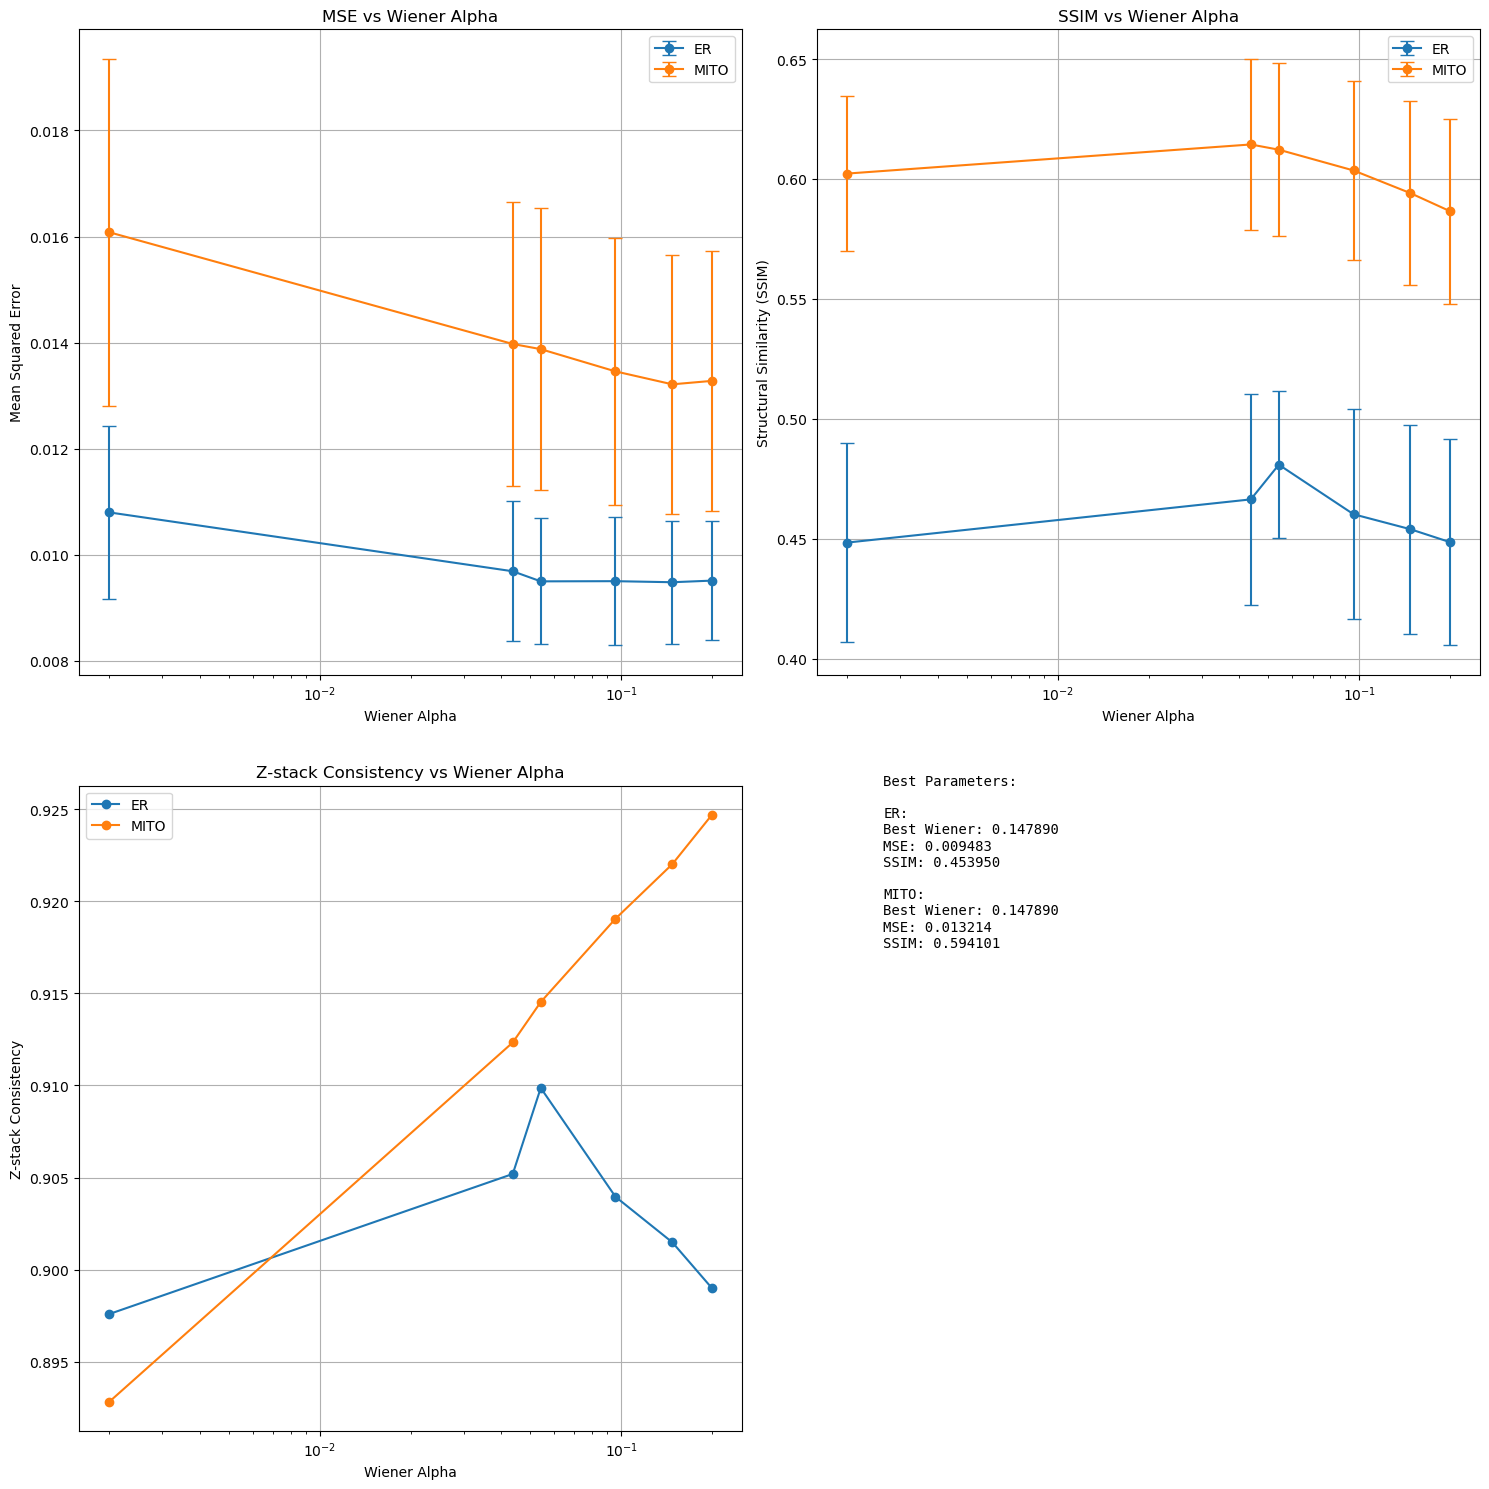

In [5]:
import napari
import numpy as np
from pathlib import Path
import tifffile
import re
import pandas as pd
from skimage import metrics
import gc
import psutil
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

def clear_memory():
    """
    Utility function to clear memory and report usage.
    Critical for handling large microscopy datasets efficiently.
    """
    plt.close('all')  # Close any open matplotlib figures
    gc.collect()      # Force garbage collection
    print(f"Memory usage: {psutil.Process().memory_info().rss / 1024 / 1024:.2f} MB")

class DeconvolutionAnalyzer:
    """
    Analyzes deconvolved microscopy images against ground truth data.
    Handles multiple Wiener parameters and compares quality across z-stacks.
    """
    def __init__(self):
        # Set up file paths
        self.base_path = Path("/home/jovyan/least squares")
        self.test_path = self.base_path / "test_deconv"
        self.viewer = None
        
        # Ground truth reference images
        self.gt_files = {
            'er': self.base_path / 'er_gt_px_108nm.tif',
            'mito': self.base_path / 'mito_gt_px_108nm.tif'
        }
        
        # Parameters for chunked processing
        self.chunk_size = 10  # Number of z-slices to process at once
        
        print("Initialization:")
        self._verify_files()
    
    def _verify_files(self):
        """Check existence of required files and report directory structure."""
        print("\nGround Truth Files:")
        for channel, path in self.gt_files.items():
            print(f"- {channel}: {path.exists()} ({path})")
            
        wiener_folders = list(self.test_path.glob("*wienerAlpha*"))
        print(f"\nWiener Alpha Folders Found: {len(wiener_folders)}")
        for folder in wiener_folders:
            print(f"- {folder.name}")

    def extract_parameters(self, filename: str, folder_path: str = None) -> dict:
        """
        Extract metadata from filename and folder structure.
        
        Parameters:
        -----------
        filename : str
            Name of deconvolved image file
        folder_path : str, optional
            Path containing Wiener alpha parameter
            
        Returns:
        --------
        dict with channel, SNR, and Wiener alpha parameters
        """
        params = {}
        
        # Extract channel type
        if 'er' in filename.lower():
            params['channel'] = 'er'
        elif 'mito' in filename.lower():
            params['channel'] = 'mito'
        
        # Extract SNR value
        snr_match = re.search(r'snr_(\d+)', filename)
        if snr_match:
            params['snr'] = int(snr_match.group(1))
        
        # Extract Wiener alpha from folder name
        if folder_path:
            wiener_match = re.search(r'wienerAlpha([\d.]+)', str(folder_path))
            if wiener_match:
                params['wiener'] = float(wiener_match.group(1))
        
        return params

    def process_z_stack(self, gt: np.ndarray, deconv: np.ndarray) -> Dict:
        """
        Process and compare a pair of z-stacks.
        
        Parameters:
        -----------
        gt : np.ndarray
            Ground truth z-stack
        deconv : np.ndarray
            Deconvolved z-stack to compare
            
        Returns:
        --------
        Dict containing spatial and temporal metrics
        """
        # Match dimensions
        min_z = min(gt.shape[0], deconv.shape[0])
        min_y = min(gt.shape[1], deconv.shape[1])
        min_x = min(gt.shape[2], deconv.shape[2])
        
        # Crop to matching size
        gt = gt[:min_z, :min_y, :min_x]
        deconv = deconv[:min_z, :min_y, :min_x]
        
        # Normalize both images to [0,1] range
        gt_norm = (gt - gt.min()) / (gt.max() - gt.min())
        deconv_norm = (deconv - deconv.min()) / (deconv.max() - deconv.min())
        
        metrics_dict = {
            'mse_values': [],
            'ssim_values': [],
            'z_consistency': []
        }
        
        # Calculate per-slice metrics
        for z in range(min_z):
            mse = metrics.mean_squared_error(gt_norm[z], deconv_norm[z])
            ssim = metrics.structural_similarity(
                gt_norm[z],
                deconv_norm[z],
                data_range=1.0
            )
            metrics_dict['mse_values'].append(mse)
            metrics_dict['ssim_values'].append(ssim)
        
        # Calculate temporal consistency between adjacent z-slices
        for z in range(min_z - 1):
            consistency = metrics.structural_similarity(
                deconv_norm[z],
                deconv_norm[z + 1],
                data_range=1.0
            )
            metrics_dict['z_consistency'].append(consistency)
        
        return metrics_dict

    def analyze_files(self):
        """Main analysis pipeline."""
        try:
            print("\nStarting analysis...")
            clear_memory()
            
            self.viewer = napari.Viewer()
            results_list = []
            
            # Process each Wiener alpha folder
            wiener_folders = list(self.test_path.glob("*wienerAlpha*"))
            
            for folder in wiener_folders:
                print(f"\nProcessing folder: {folder.name}")
                clear_memory()
                
                # Process each image in the folder
                for test_file in folder.glob("CamB_ch0*.tif"):
                    params = self.extract_parameters(test_file.name, folder)
                    channel = params['channel']
                    
                    print(f"\nAnalyzing: {test_file.name}")
                    print(f"Parameters: {params}")
                    
                    # Load and process images
                    gt = tifffile.imread(str(self.gt_files[channel]))
                    deconv = tifffile.imread(str(test_file))
                    
                    # Calculate metrics
                    metrics_dict = self.process_z_stack(gt, deconv)
                    
                    # Store results
                    results_list.append({
                        'channel': channel,
                        'snr': params['snr'],
                        'wiener': params['wiener'],
                        'mse_mean': np.mean(metrics_dict['mse_values']),
                        'mse_std': np.std(metrics_dict['mse_values']),
                        'ssim_mean': np.mean(metrics_dict['ssim_values']),
                        'ssim_std': np.std(metrics_dict['ssim_values']),
                        'z_consistency': np.mean(metrics_dict['z_consistency'])
                    })
                    
                    # Show central z-slice in viewer
                    mid_z = len(metrics_dict['mse_values']) // 2
                    self.viewer.add_image(
                        deconv[mid_z],
                        name=f"{channel}_W{params['wiener']}_SNR{params['snr']}",
                        visible=True
                    )
                    
                    # Clean up large arrays
                    del gt, deconv
                    clear_memory()
            
            # Create results DataFrame and plot
            self.results = pd.DataFrame(results_list)
            self.plot_comprehensive_results()
            
            return self.viewer
            
        except Exception as e:
            print(f"Error in analysis: {e}")
            raise

    def plot_comprehensive_results(self):
        """Generate comprehensive visualization of results."""
        if not hasattr(self, 'results') or self.results.empty:
            return
            
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        
        # Plot MSE vs Wiener Alpha
        for channel in ['er', 'mito']:
            channel_data = self.results[self.results['channel'] == channel].sort_values('wiener')
            axes[0,0].errorbar(
                channel_data['wiener'],
                channel_data['mse_mean'],
                yerr=channel_data['mse_std'],
                fmt='o-',
                label=channel.upper(),
                capsize=5
            )
        
        axes[0,0].set_xscale('log')
        axes[0,0].set_xlabel('Wiener Alpha')
        axes[0,0].set_ylabel('Mean Squared Error')
        axes[0,0].set_title('MSE vs Wiener Alpha')
        axes[0,0].grid(True)
        axes[0,0].legend()
        
        # Plot SSIM vs Wiener Alpha
        for channel in ['er', 'mito']:
            channel_data = self.results[self.results['channel'] == channel].sort_values('wiener')
            axes[0,1].errorbar(
                channel_data['wiener'],
                channel_data['ssim_mean'],
                yerr=channel_data['ssim_std'],
                fmt='o-',
                label=channel.upper(),
                capsize=5
            )
        
        axes[0,1].set_xscale('log')
        axes[0,1].set_xlabel('Wiener Alpha')
        axes[0,1].set_ylabel('Structural Similarity (SSIM)')
        axes[0,1].set_title('SSIM vs Wiener Alpha')
        axes[0,1].grid(True)
        axes[0,1].legend()
        
        # Plot Z-consistency
        for channel in ['er', 'mito']:
            channel_data = self.results[self.results['channel'] == channel].sort_values('wiener')
            axes[1,0].plot(
                channel_data['wiener'],
                channel_data['z_consistency'],
                'o-',
                label=channel.upper()
            )
        
        axes[1,0].set_xscale('log')
        axes[1,0].set_xlabel('Wiener Alpha')
        axes[1,0].set_ylabel('Z-stack Consistency')
        axes[1,0].set_title('Z-stack Consistency vs Wiener Alpha')
        axes[1,0].grid(True)
        axes[1,0].legend()
        
        # Add best parameters summary
        axes[1,1].axis('off')
        summary_text = "Best Parameters:\n\n"
        for channel in ['er', 'mito']:
            channel_data = self.results[self.results['channel'] == channel]
            best_result = channel_data.loc[channel_data['mse_mean'].idxmin()]
            summary_text += f"{channel.upper()}:\n"
            summary_text += f"Best Wiener: {best_result['wiener']:.6f}\n"
            summary_text += f"MSE: {best_result['mse_mean']:.6f}\n"
            summary_text += f"SSIM: {best_result['ssim_mean']:.6f}\n\n"
        
        axes[1,1].text(0.1, 0.7, summary_text, fontsize=10, family='monospace')
        
        plt.tight_layout()
        plt.show()

# Usage
if __name__ == "__main__":
    analyzer = DeconvolutionAnalyzer()
    viewer = analyzer.analyze_files()